In [1]:
!pip install matplotlib pandas imageio

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!pip install nvcc4jupyter

%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmplxsllxub".


In [4]:
!apt-get install -y build-essential
!apt-get install -y gcc
!apt-get install -y g++-multilib
!apt-get install -y cuda

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gcc is already the newest version (4:11.2.0-1ubuntu1).
gcc set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  g++-11-multilib gcc-11-multilib gcc-multilib lib32asan6 lib32atomic1 lib32gcc-11-dev lib32gomp1
  lib32itm1 lib32quadmath0 lib32stdc++-11-dev lib32ubsan1 libc6-dev-i386 libc6-dev-x32 libc6-x32
  libx32asan6 libx32atomic1 libx32gcc-11-dev libx32gcc-s1 libx32gomp1 libx32itm1 libx32quadmath0
  libx32stdc++-11-dev libx32stdc++6 libx32ubsan1
Suggested packages:
  lib32stdc++6-11-db


1. **Инициализация:**
   - Из входного файла считываются параметры: количество тел (points), количество шагов моделирования (steps), число повторений (repeats), количество потоков (threads) и временной шаг (delta).
   - Для каждого тела задаются начальные условия: масса, координаты (x, y) и скорости (vx, vy).

2. **Гравитационная модель:**
   - Сила гравитационного притяжения между двумя телами массами m_i и m_j на расстоянии r определяется законом всемирного тяготения Ньютона
   - В двумерной постановке каждая сила разбивается на компоненты по осям x и y, и суммируется по всем телам, кроме рассматриваемого.

3. **Численный метод:**
   - Обновление положения и скорости тел выполняется по методу Эйлера

4. **Параллелизация на GPU (CUDA):**
   - Для ускорения вычислений используется GPU: каждый поток (thread) на GPU вычисляет силы, действующие на отдельное тело.
   - Память для позиций, скоростей и масс тел копируется на видеокарту.
   - Запуск CUDA-ядра выполняется на каждом шаге: все тела параллельно обрабатываются, вычисляются их новые координаты и скорости.
   - После каждого шага результаты (координаты и скорости) возвращаются на хост (CPU), чтобы при необходимости их сохранить или обработать дальше.

5. **Повторения и вывод результатов:**
   - Моделирование выполняется заданное число шагов. Если указано несколько повторов (repeats), алгоритм заново считывает начальные условия и пересчитывает всю последовательность шагов для оценки стабильности и усреднения времени.
   - После завершения последнего повтора результаты (положения тел на каждом временном шаге) записываются в CSV-файл для визуализации и анализа.
   - Выводится среднее время исполнения среди повторов (Avg ms).

In [5]:
code = r"""
#include <iostream>
#include <fstream>
#include <cmath>
#include <sys/time.h>
#include <cuda_runtime.h>
#include <cstdlib>

#define G 6.67430e-11f
#define DEFAULT_DELTA 1e-3f

struct Pair {
    float x;
    float y;
};

struct Points {
    Pair* coords;
    Pair* velocities;
    int size;
};

struct PointsPaths {
    int points_number;
    int steps_number;
    int repeats_number;
    int threads_number;
    float delta;
    float* time;
    float* masses;
    Points** points;
};

PointsPaths* read_input_file(const char* input_file) {
    std::ifstream input(input_file);
    if (!input.is_open()) {
        std::cerr << "Failed to open input file: " << input_file << "\n";
        exit(EXIT_FAILURE);
    }

    int n, steps, repeats, threads;
    float delta;
    input >> n >> steps >> repeats >> threads >> delta;

    PointsPaths* paths = (PointsPaths*)malloc(sizeof(PointsPaths));
    paths->points_number = n;
    paths->steps_number = steps;
    paths->repeats_number = repeats;
    paths->threads_number = threads;
    paths->delta = delta;

    paths->time = (float*)malloc(steps * sizeof(float));
    paths->masses = (float*)malloc(n * sizeof(float));
    paths->points = (Points**)malloc(steps * sizeof(Points*));

    Points* initial_points = (Points*)malloc(sizeof(Points));
    initial_points->coords = (Pair*)malloc(n * sizeof(Pair));
    initial_points->velocities = (Pair*)malloc(n * sizeof(Pair));
    initial_points->size = n;

    for (int i = 0; i < n; ++i) {
        float m, x, y, vx, vy;
        input >> m >> x >> y >> vx >> vy;
        paths->masses[i] = m;
        initial_points->coords[i].x = x;
        initial_points->coords[i].y = y;
        initial_points->velocities[i].x = vx;
        initial_points->velocities[i].y = vy;
    }

    paths->points[0] = initial_points;
    paths->time[0] = 0.0f;
    input.close();
    return paths;
}

void write_output_csv(const char* output_file, PointsPaths* paths) {
    std::ofstream output(output_file);
    int n = paths->points_number;
    int iterations = paths->steps_number;
    output << "timestamp,";
    for (int i = 0; i < n - 1; ++i) {
        output << "x" << i+1 << ",y" << i+1 << ",";
    }
    output << "x" << n << ",y" << n << "\n";
    for (int i = 0; i < iterations; ++i) {
        output << paths->time[i] << ",";
        Points* point = paths->points[i];
        for (int j = 0; j < n; ++j) {
            output << point->coords[j].x << "," << point->coords[j].y;
            if (j != n - 1) output << ",";
        }
        output << "\n";
    }
    output.close();
}

__global__ void update_positions_velocities(int n, float delta, const float* masses, 
                                            const float* old_x, const float* old_y,
                                            const float* old_vx, const float* old_vy,
                                            float* new_x, float* new_y,
                                            float* new_vx, float* new_vy) 
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float current_x = old_x[i];
        float current_y = old_y[i];

        float fx = 0.0f, fy = 0.0f;
        for (int j = 0; j < n; ++j) {
            if (j != i) {
                float dx = old_x[j] - current_x;
                float dy = old_y[j] - current_y;
                float dist_sq = dx * dx + dy * dy;
                if (dist_sq >= 1e-6f) {
                    float dist = sqrtf(dist_sq);
                    float dist_cubed = dist_sq * dist;
                    float mass_factor = masses[j] / dist_cubed;
                    fx += mass_factor * dx;
                    fy += mass_factor * dy;
                }
            }
        }

        fx *= G * masses[i];
        fy *= G * masses[i];

        new_x[i] = current_x + old_vx[i] * delta;
        new_y[i] = current_y + old_vy[i] * delta;

        new_vx[i] = old_vx[i] + (fx / masses[i]) * delta;
        new_vy[i] = old_vy[i] + (fy / masses[i]) * delta;
    }
}

void calculate_with_cuda(PointsPaths* paths) {
    int n = paths->points_number;
    int steps = paths->steps_number;
    float delta = paths->delta;

    float *d_masses, *d_x, *d_y, *d_vx, *d_vy, *d_new_x, *d_new_y, *d_new_vx, *d_new_vy;
    cudaMalloc((void**)&d_masses, n * sizeof(float));
    cudaMalloc((void**)&d_x, n * sizeof(float));
    cudaMalloc((void**)&d_y, n * sizeof(float));
    cudaMalloc((void**)&d_vx, n * sizeof(float));
    cudaMalloc((void**)&d_vy, n * sizeof(float));
    cudaMalloc((void**)&d_new_x, n * sizeof(float));
    cudaMalloc((void**)&d_new_y, n * sizeof(float));
    cudaMalloc((void**)&d_new_vx, n * sizeof(float));
    cudaMalloc((void**)&d_new_vy, n * sizeof(float));

    Points* initial = paths->points[0];
    float *h_x = (float*)malloc(n * sizeof(float));
    float *h_y = (float*)malloc(n * sizeof(float));
    float *h_vx = (float*)malloc(n * sizeof(float));
    float *h_vy = (float*)malloc(n * sizeof(float));

    for (int i = 0; i < n; i++) {
        h_x[i] = initial->coords[i].x;
        h_y[i] = initial->coords[i].y;
        h_vx[i] = initial->velocities[i].x;
        h_vy[i] = initial->velocities[i].y;
    }

    cudaMemcpy(d_masses, paths->masses, n * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_x, h_x, n * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_y, h_y, n * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_vx, h_vx, n * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_vy, h_vy, n * sizeof(float), cudaMemcpyHostToDevice);

    int threads_per_block = paths->threads_number;
    int blocks = (n + threads_per_block - 1) / threads_per_block;

    for (int current = 1; current < steps; ++current) {
        update_positions_velocities<<<blocks, threads_per_block>>>(
            n, delta, d_masses, d_x, d_y, d_vx, d_vy, d_new_x, d_new_y, d_new_vx, d_new_vy
        );
        cudaDeviceSynchronize();

        cudaMemcpy(h_x, d_new_x, n * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_y, d_new_y, n * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(h_y, d_new_y, n * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_vx, d_new_vx, n * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_vy, d_new_vy, n * sizeof(float), cudaMemcpyDeviceToHost);

        Points* points = (Points*)malloc(sizeof(Points));
        points->coords = (Pair*)malloc(n * sizeof(Pair));
        points->velocities = (Pair*)malloc(n * sizeof(Pair));
        points->size = n;

        for (int i = 0; i < n; i++) {
            points->coords[i].x = h_x[i];
            points->coords[i].y = h_y[i];
            points->velocities[i].x = h_vx[i];
            points->velocities[i].y = h_vy[i];
        }

        paths->time[current] = paths->time[current - 1] + delta;
        paths->points[current] = points;

        float* tmp_x = d_x; d_x = d_new_x; d_new_x = tmp_x;
        float* tmp_y = d_y; d_y = d_new_y; d_new_y = tmp_y;
        float* tmp_vx = d_vx; d_vx = d_new_vx; d_new_vx = tmp_vx;
        float* tmp_vy = d_vy; d_vy = d_new_vy; d_new_vy = tmp_vy;
    }

    free(h_x); free(h_y); free(h_vx); free(h_vy);
    cudaFree(d_masses); cudaFree(d_x); cudaFree(d_y); cudaFree(d_vx); cudaFree(d_vy);
    cudaFree(d_new_x); cudaFree(d_new_y); cudaFree(d_new_vx); cudaFree(d_new_vy);
}

void release(PointsPaths* paths) {
    for (int i = 0; i < paths->steps_number; ++i) {
        free(paths->points[i]->coords);
        free(paths->points[i]->velocities);
        free(paths->points[i]);
    }
    free(paths->points);
    free(paths->masses);
    free(paths->time);
}

void do_simulation(const char* input_file, const char* output_file) {
    PointsPaths* paths = read_input_file(input_file);

    struct timeval begin, end;
    long long avg_ms = 0;

    for (int i = 0; i < paths->repeats_number; ++i) {
        PointsPaths* local_paths = read_input_file(input_file);

        gettimeofday(&begin, 0);
        calculate_with_cuda(local_paths);
        gettimeofday(&end, 0);

        long long elapsed_ms = (end.tv_sec - begin.tv_sec)*1000LL + (end.tv_usec - begin.tv_usec)/1000LL;
        std::cout << "Repeat " << (i+1) << " took " << elapsed_ms << " ms\n";
        avg_ms += elapsed_ms;

        if (i == paths->repeats_number - 1) {
            write_output_csv(output_file, local_paths);
        }

        release(local_paths);
    }

    avg_ms /= paths->repeats_number;
    std::cout << "Avg " << avg_ms << " ms\n";

    free(paths->points[0]->coords);
    free(paths->points[0]->velocities);
    free(paths->points[0]);
    free(paths->points);
    free(paths->masses);
    free(paths->time);
    free(paths);
}

int main(int argc, char* argv[]) {
    if (argc != 3) {
        std::cerr << "Usage: " << argv[0] << " <input_file> <output_file>\n";
        return EXIT_FAILURE;
    }

    const char* input = argv[1];
    const char* output = argv[2];

    do_simulation(input, output);
    return 0;
}
"""

with open("n_body_simulation.cu", 'w') as file:
    file.write(code)


In [6]:
!nvcc -o n_body_simulation n_body_simulation.cu

In [7]:
import pandas as pd
import numpy as np
import subprocess
import re
import matplotlib.pyplot as plt
import os
import imageio
import glob
from math import sqrt


input_dir = "input_files"
output_dir = "output_files"
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

def generate_input_file(points, steps, repeats, threads, delta=1e-3, filename="input.txt"):
    masses = np.random.uniform(1e10, 1e11, size=points)
    coords_x = np.random.uniform(-1e3, 1e3, size=points)
    coords_y = np.random.uniform(-1e3, 1e3, size=points)
    vel_x = np.random.uniform(-1e2, 1e2, size=points)
    vel_y = np.random.uniform(-1e2, 1e2, size=points)

    with open(f'/content/input_files/{filename}', "w") as f:
        f.write(f"{points} {steps} {repeats} {threads} {delta}\n")
        for i in range(points):
            f.write(f"{masses[i]} {coords_x[i]} {coords_y[i]} {vel_x[i]} {vel_y[i]}\n")


In [24]:
# Параметры для тестирования
thread_list = [1, 2, 4, 8, 32, 64, 128, 256]  # Число потоков (на блок)
points_list = [10, 100, 1000, 2000, 5000]  # Число точек
steps = 1000
repeats = 5
delta = 1e-3

results = []

In [25]:
for points in points_list:
    for threads in thread_list:
        input_file = f"input_{threads}_{points}"
        output_file = f"output_{threads}_{points}.csv"

        generate_input_file(points, steps, repeats, threads, delta, filename=input_file)

        cmd = f"./n_body_simulation /content/input_files/{input_file} /content/output_files/{output_file}"
        proc = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)

        stdout = proc.stdout
        match = re.search(r"Avg\s+(\d+)\s+ms", stdout)
        if match:
            avg_ms = int(match.group(1))
        else:
            avg_ms = None

        print(f"Threads: {threads}, Points: {points}, Avg Time: {avg_ms} ms")

        results.append((points, threads, avg_ms))


Threads: 1, Points: 10, Avg Time: 66 ms
Threads: 2, Points: 10, Avg Time: 64 ms
Threads: 4, Points: 10, Avg Time: 66 ms
Threads: 8, Points: 10, Avg Time: 67 ms
Threads: 32, Points: 10, Avg Time: 67 ms
Threads: 64, Points: 10, Avg Time: 70 ms
Threads: 128, Points: 10, Avg Time: 66 ms
Threads: 256, Points: 10, Avg Time: 69 ms
Threads: 1, Points: 100, Avg Time: 94 ms
Threads: 2, Points: 100, Avg Time: 75 ms
Threads: 4, Points: 100, Avg Time: 76 ms
Threads: 8, Points: 100, Avg Time: 85 ms
Threads: 32, Points: 100, Avg Time: 88 ms
Threads: 64, Points: 100, Avg Time: 90 ms
Threads: 128, Points: 100, Avg Time: 89 ms
Threads: 256, Points: 100, Avg Time: 88 ms
Threads: 1, Points: 1000, Avg Time: 416 ms
Threads: 2, Points: 1000, Avg Time: 239 ms
Threads: 4, Points: 1000, Avg Time: 226 ms
Threads: 8, Points: 1000, Avg Time: 225 ms
Threads: 32, Points: 1000, Avg Time: 291 ms
Threads: 64, Points: 1000, Avg Time: 249 ms
Threads: 128, Points: 1000, Avg Time: 232 ms
Threads: 256, Points: 1000, Avg Tim

In [26]:
# Создадим DataFrame
df = pd.DataFrame(results, columns=["Points", "Threads", "Time_ms"])

acceleration_values = []
for p in df["Points"].unique():
    subset = df[df["Points"] == p]
    # Берем минимальный Threads
    min_threads = subset["Threads"].min()
    baseline_time = subset[subset["Threads"] == min_threads]["Time_ms"].values[0]
    for idx, row in subset.iterrows():
        acceleration = baseline_time / row["Time_ms"]
        acceleration_values.append((idx, acceleration))

for idx, acc in acceleration_values:
    df.loc[idx, "Acceleration"] = acc

df

,Points,Threads,Time_ms,Acceleration
0,10,1,66,1.000000
1,10,2,64,1.031250
2,10,4,66,1.000000
3,10,8,67,0.985075
4,10,32,67,0.985075
5,10,64,70,0.942857
6,10,128,66,1.000000
7,10,256,69,0.956522
8,100,1,94,1.000000
9,100,2,75,1.253333


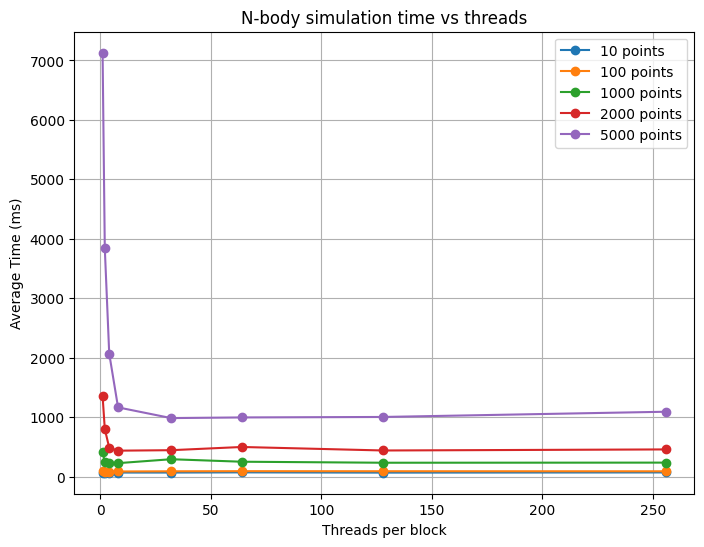

In [27]:
# Строим графики зависимости времени от числа потоков для каждого числа точек
plt.figure(figsize=(8,6))
for p in df["Points"].unique():
    subset = df[df["Points"] == p].sort_values("Threads")
    plt.plot(subset["Threads"], subset["Time_ms"], marker='o', label=f"{p} points")

plt.xlabel("Threads per block")
plt.ylabel("Average Time (ms)")
plt.title("N-body simulation time vs threads")
plt.grid(True)
plt.legend()
plt.show()

- При малом числе точек увеличение числа потоков практически не снижает время, так как накладные расходы на параллелизацию превышают выгоду.
- По мере увеличения числа точек время при 1 потоке растёт, и распараллеливание начинает существенно снижать время, приблизительно в 2-3 и более раз.
- При очень большом числе точек можно достичь значительного ускорения за счёт параллелизма, но после определённого количества потоков нарастают накладные расходы, и время перестаёт уменьшаться или даже слегка увеличивается.

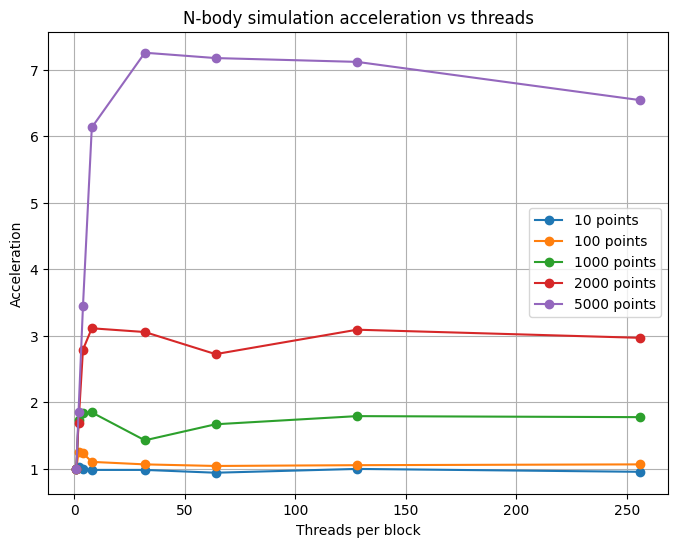

In [28]:
# Строим график зависимости ускорения от числа потоков для каждого числа точек
plt.figure(figsize=(8,6))
for p in df["Points"].unique():
    subset = df[df["Points"] == p].sort_values("Threads")
    plt.plot(subset["Threads"], subset["Acceleration"], marker='o', label=f"{p} points")

plt.xlabel("Threads per block")
plt.ylabel("Acceleration")
plt.title("N-body simulation acceleration vs threads")
plt.grid(True)
plt.legend()
plt.show()

- Для небольшого числа точек ускорение близко к 1, иногда чуть меньше, так как параллелизация не даёт выгоды.
- Для среднего и большого числа точек ускорение возрастает по мере увеличения потоков, иногда достигая 2-3-кратного или даже выше увеличения производительности, прежде чем достигнет плато или начнёт падать.
- На очень больших задачах ускорение может быть особенно впечатляющим при оптимальном количестве потоков, но слишком большое количество потоков не всегда приводит к дальнейшему увеличению ускорения.

In [41]:
def create_gif_from_csv(csv_file, gif_name="simulation.gif"):
    df_positions = pd.read_csv(csv_file)
    cols = df_positions.columns
    body_cols = cols[1:]
    num_bodies = len(body_cols) // 2

    frames_dir = "gif_frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Найдем глобальные границы для всего движения, чтобы масштаб не менялся
    all_x = []
    all_y = []
    for i in range(num_bodies):
        x_col = f"x{i+1}"
        y_col = f"y{i+1}"
        all_x.extend(df_positions[x_col].values)
        all_y.extend(df_positions[y_col].values)

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    # Создаем кадры
    frame_files = []
    for idx, row in df_positions.iterrows():
        plt.figure(figsize=(6,6))
        for i in range(num_bodies):
            x_col = f"x{i+1}"
            y_col = f"y{i+1}"
            plt.scatter(row[x_col], row[y_col], s=50)
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        plt.title(f"Time: {row['timestamp']}")
        plt.xlabel("X")
        plt.ylabel("Y")
        frame_file = os.path.join(frames_dir, f"frame_{idx}.png")
        plt.savefig(frame_file)
        plt.close()
        frame_files.append(frame_file)

    # Создаем gif
    images = []
    for ff in frame_files:
        images.append(imageio.imread(ff))
    imageio.mimsave(gif_name, images, fps=50)
    print("GIF created:", gif_name)

In [42]:
create_gif_from_csv("/content/output_files/output_1_10.csv")

<ipython-input-41-951c49a76a8c>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(ff))


GIF created: simulation.gif


### Моделирование солнечной системы

In [39]:
def generate_solar_system(steps, repeats, threads, delta=1e-3, filename="solar_system_input.txt"):
    points = 6
    masses = [1e30] + [1e24, 5e24, 1e25, 1e26, 5e26]
    radii = [0, 1e11, 1.5e11, 2e11, 2.5e11, 3e11]
    G = 6.67430e-11
    M = 1e30

    coords_x = []
    coords_y = []
    vel_x = []
    vel_y = []

    for i, r in enumerate(radii):
        if i == 0:
            coords_x.append(0.0)
            coords_y.append(0.0)
            vel_x.append(0.0)
            vel_y.append(0.0)
        else:
            coords_x.append(r)
            coords_y.append(0.0)
            v = sqrt(G * M / r)
            vel_x.append(0.0)
            vel_y.append(v)

    with open(filename, "w") as f:
        f.write(f"{points} {steps} {repeats} {threads} {delta}\n")
        for i in range(points):
            f.write(f"{masses[i]} {coords_x[i]} {coords_y[i]} {vel_x[i]} {vel_y[i]}\n")


In [ ]:
generate_solar_system(steps=1000, repeats=1, threads=64, filename="solar_input_file")
cmd = f"./n_body_simulation solar_input_file solar_input_file.csv"
subprocess.run(cmd, shell=True, check=True)


create_gif_from_csv("solar_input_file.csv", "solar_system_simulation.gif")

<ipython-input-41-951c49a76a8c>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(ff))
